<a href="https://colab.research.google.com/github/satoshi19989/transformer_practice/blob/main/transformer_time_series2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [ ]:
module_path = "/content/drive/MyDrive/modules"
sys.path.append(module_path)

# 対象データ確認

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-17 22:38:31--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.201.112, 52.216.139.229, 52.217.133.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.201.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  60.3MB/s    in 0.2s    

2023-02-17 22:38:31 (60.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
#例１

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


#例2

# data_path = os.path.join(module_path, "influenza_transformer/data")
# data = pd.read_csv(os.path.join(data_path, "dfs_merged_upload.csv"), index_col=0)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


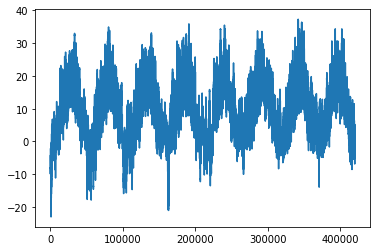

In [ ]:
from matplotlib import pyplot as plt

#例1
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

plt.plot(range(len(temperature)), temperature)


#例2
# plt.figure()
# plt.plot(data['FCR_N_PriceEUR'])

# データ前処理

In [ ]:
import generate_data as gd
import utility
from utility import resampling



#例1
#raw_data = resampling(raw_data, 6)
batch_size = 256
window_width =120
pred_points = 24

#例2
# raw_data = data['FCR_N_PriceEUR'].values
# raw_data = raw_data[:-1925]

# batch_size = 100
# window_width =20
# pred_points = 10

predata = gd.PreprocessData(raw_data, batch_size, window_width, pred_points, 6, 1)

# 学習用データ生成

In [ ]:
from generate_data import textbook_method

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset, val_dataset, test_dataset = textbook_method(raw_data, temperature, sampling_rate, sequence_length, delay, batch_size)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
#transformerの場合
enc_train, dec_train, y_train, enc_val, dec_val, y_val, enc_test, dec_test, y_test = predata.make_data_for_transformer()
input = tf.concat([enc_train, dec_train], axis=1)
val_input = tf.concat([enc_val, dec_val], axis=1)
val_data = (val_input, y_val)

#NNの場合
x_train, y_train, x_val, y_val, x_test, y_test = predata.make_data_for_NN()



input_train  (34816, 120, 14)
y_train  (34816,)
input_val  (17408, 120, 14)
y_val  (17408,)
input_test  (17152, 120, 14)
y_test  (17152,)


In [ ]:
import utility

train_data = raw_data[:predata.num_train_samples]
val_data = raw_data[predata.num_train_samples : predata.num_train_samples+predata.num_val_samples]
test_data = raw_data[predata.num_train_samples + predata.num_val_samples : predata.num_train_samples + predata.num_val_samples + predata.num_test_samples]

test_mae, y_pred_naive = utility.evaluate_naive_method(test_data)

#print(f"Validation MAE: {evaluate_naive_method(val_data):.2f}")
print(f"Test MAE: {test_mae:.2f}")

Test MAE: 2.38


# 基本的なNNを試す

In [ ]:
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers

class MyLayer(tf.keras.layers.Layer):
  def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
      super().__init__(trainable, name, dtype, dynamic, **kwargs)

      self.flat = layers.Flatten()
      self.layer1 = layers.Dense(16, activation="relu")
      self.layer2 = layers.Dense(1)

  def call(self, x):
    print(x.shape)
    x = self.flat(x)
    x = self.layer1(x)
    x = self.layer2(x)
    return x

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
outputs = MyLayer()(inputs)
model = keras.Model(inputs, outputs)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# history = model.fit(x_train, 
#                     y_train, 
#                     epochs=10,
#                     #batch_size=batch_size, 
#                     validation_data=(x_val, y_val),
#                     callbacks=callbacks)

history = model.fit(train_dataset, 
                    epochs=10,
                    batch_size=batch_size, 
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras", custom_objects={'MyLayer':MyLayer})

print(f"Test MAE: {model.evaluate(x_test, y_test)[1]:.2f}")

(None, 120, 14)
Epoch 1/10
(None, 120, 14)
(None, 120, 14)
819/819 [==============================] - 58s 69ms/step - loss: 11.8802 - mae: 2.6696 - val_loss: 10.9544 - val_mae: 2.6091
Epoch 2/10
819/819 [==============================] - 56s 69ms/step - loss: 8.7167 - mae: 2.3203 - val_loss: 10.5987 - val_mae: 2.5671
Epoch 3/10
819/819 [==============================] - 58s 70ms/step - loss: 8.0300 - mae: 2.2254 - val_loss: 10.7199 - val_mae: 2.5914
Epoch 4/10
819/819 [==============================] - 55s 67ms/step - loss: 7.6188 - mae: 2.1682 - val_loss: 11.3213 - val_mae: 2.6626
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 7.3211 - mae: 2.1259 - val_loss: 11.3968 - val_mae: 2.6609
Epoch 6/10
819/819 [==============================] - 57s 70ms/step - loss: 7.1142 - mae: 2.0958 - val_loss: 10.4062 - val_mae: 2.5446
Epoch 7/10
819/819 [==============================] - 58s 70ms/step - loss: 6.9464 - mae: 2.0699 - val_loss: 10.9125 - val_mae: 2.6128
Epoch 

ValueError: ignored

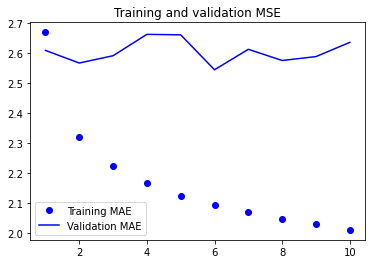

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MSE")
plt.legend()
plt.show()

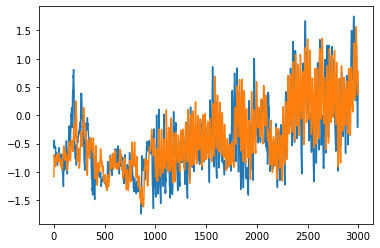

In [ ]:
end_point = 3000

plt.figure()
plt.plot(y_test[:end_point])
plt.plot(y_pred[:end_point,0])

In [ ]:
MSE, r2 = utility.calc_score(y_test, y_pred[:,0])
print("MSE : ", MSE)
print("r2 : ", r2)

MSE :  0.38244757104208854
r2 :  0.8241300222865205


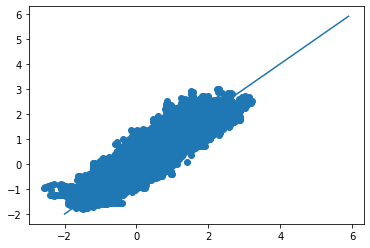

In [ ]:
x = np.arange(-2, 6, 0.1)
y = x

plt.figure()
plt.scatter(y_test, y_pred[:,0])
plt.plot(x, y)

# トランスフォーマの構築

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from transformer_layers import Encoder
import transformer_core as tfc
from transformer_core import TransformerBaseTimeSeriesForecastModel, EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel

dmodel = 16

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)


# inputs = keras.Input(shape=(None,))
# x = Encoder(4, dmodel, 1, 100, sequence_length, 20000, 0.2)(x, True, None)  # (batch_size, inp_seq_len, d_model)
# outputs = layers.Dense(1)(x)

# model = keras.Model(inputs, outputs)

# model = TransformerBaseTimeSeriesForecastModel(num_layers=4, # Multi-head Attentionの繰り返し数
#                                                   d_model = dmodel, # embeddingの次元
#                                                   num_heads=1,  # Multi-head Attentionのヘッド数
#                                                   dff = 100,      #全結合層のユニット数
#                                                   input_vocab_size = window_width, 
#                                                   target_vocab_size = pred_points, 
#                                                   pe_input = 20000, 
#                                                   pe_target = 10000,
#                                                   window_width = window_width, 
#                                                   rate=0.2)

# model = EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel(num_layers=4, # Multi-head Attentionの繰り返し数
#                                                   d_model = dmodel, # embeddingの次元
#                                                   num_heads=1,  # Multi-head Attentionのヘッド数
#                                                   dff = 100,      #全結合層のユニット数
#                                                   input_vocab_size = sequence_length, 
#                                                   pe_input = 20000, 
#                                                   window_width = sequence_length, 
#                                                   rate=0.2)


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
outputs = EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel(num_layers=4, # Multi-head Attentionの繰り返し数
                                                  d_model = dmodel, # embeddingの次元
                                                  num_heads=1,  # Multi-head Attentionのヘッド数
                                                  dff = 100,      #全結合層のユニット数
                                                  input_vocab_size = sequence_length, 
                                                  pe_input = 20000, 
                                                  window_width = sequence_length, 
                                                  rate=0.2)(inputs)
model = keras.Model(inputs, outputs)


#model.build(input_shape=(batch_size, sequence_length, 14))
model.compile(loss=criterion, optimizer=optimizer, metrics=['mae'])




(None, 120, 14)


In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 encoder_with_multi_head_att  (None, 120, 1)           18129     
 ention_base_time_series_for                                     
 ecast_model_2 (EncoderWithM                                     
 ultiHeadAttentionBaseTimeSe                                     
 riesForecastModel)                                              
                                                                 
Total params: 18,129
Trainable params: 18,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# input = tf.concat([enc_train, dec_train], axis=1)
# val_input = tf.concat([enc_val, dec_val], axis=1)
# val_data = (val_input, y_val)

# print(val_input.shape, y_val.shape)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    lr_decay
    , keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
#history=model.fit(input, y_train, batch_size=batch_size, epochs=10, validation_data=val_data, callbacks=callbacks,verbose=2)
history=model.fit(train_dataset, batch_size=batch_size, epochs=10, validation_data=val_dataset, callbacks=callbacks,verbose=2)
model = keras.models.load_model("jena_dense.keras", 
                                custom_objects={"EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel":EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel})

Epoch 1/10
(None, 120, 14)
(None, 120, 14)
(None, 120, 14)
819/819 - 822s - loss: 163.8678 - mae: 10.6619 - val_loss: 177.0471 - val_mae: 11.1791 - lr: 0.0000e+00 - 822s/epoch - 1s/step
Epoch 2/10
819/819 - 765s - loss: 123.6474 - mae: 9.0882 - val_loss: 96.7443 - val_mae: 8.0332 - lr: 1.1314e-05 - 765s/epoch - 935ms/step
Epoch 3/10
819/819 - 755s - loss: 91.2959 - mae: 7.7553 - val_loss: 82.9286 - val_mae: 7.4490 - lr: 2.2627e-05 - 755s/epoch - 922ms/step
Epoch 4/10
819/819 - 762s - loss: 84.7993 - mae: 7.4718 - val_loss: 76.9781 - val_mae: 7.1914 - lr: 3.3941e-05 - 762s/epoch - 931ms/step
Epoch 5/10
819/819 - 758s - loss: 80.1760 - mae: 7.2634 - val_loss: 70.6587 - val_mae: 6.9052 - lr: 4.5255e-05 - 758s/epoch - 925ms/step
Epoch 6/10
819/819 - 757s - loss: 76.9932 - mae: 7.1136 - val_loss: 66.2660 - val_mae: 6.6998 - lr: 5.6569e-05 - 757s/epoch - 924ms/step
Epoch 7/10
819/819 - 729s - loss: 76.1963 - mae: 7.0734 - val_loss: 65.5765 - val_mae: 6.6664 - lr: 6.7882e-05 - 729s/epoch - 89

TypeError: ignored

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
test_input = tf.concat([enc_test, dec_test], axis=1)
y_pred = model.predict(test_input)
y_pred.shape

False (32, 120, 14)
536/536 [==============================] - 35s 61ms/step


(17152, 24, 1)

In [ ]:
y_test.shape

TensorShape([17152, 24])

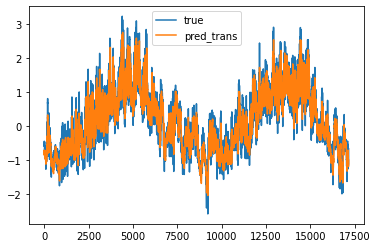

In [ ]:
start_point = 0
end_point = 30000

plt.figure()
plt.plot(y_test[start_point:end_point,-1], label="true")
plt.plot(y_pred[start_point:end_point,-1,0], label="pred_trans")
#plt.plot(y_pred_naive[start_point+29 : end_point+29], label="naive")
plt.legend()

In [ ]:

MSE, r2 = utility.calc_score(y_test[:,-1], y_pred[:,-1,0])
print(MSE, r2)

0.20853984289677904 0.9477040455568707


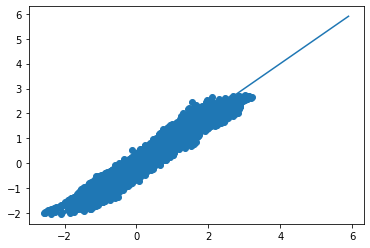

In [ ]:
x = np.arange(-2, 6, 0.1)
y = x

plt.figure()
plt.scatter(y_test[:,-1], y_pred[:,-1,0])
plt.plot(x, y)

# 教科書の実装

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
from transformer_layers import positional_encoding

# vocab_size = 20000
# embed_dim = 256
# num_heads = 2
# dense_dim = 32

pos_encoding = positional_encoding(20000, dmodel)

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(sequence_length, dmodel)(inputs)
#x = inputs + pos_encoding[:, :sequence_length, :]
x = TransformerEncoder(dmodel, 100, 1)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss=criterion, optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 16)          1920      
                                                                 
 transformer_encoder_63 (Tra  (None, None, 16)         4468      
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_137 (Dropout)       (None, 16)                0         
                                                                 
 dense_177 (Dense)           (None, 1)                 17  

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

Epoch 1/20


ValueError: ignored